In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from database import *


/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
batch_size = 2

mr = ModelReader(batch_size)

Connecting to the PostgreSQL database...


In [3]:
batch = mr.getGraspBatch()

one_grasp = batch[1]
params = config(section='data')

scale, grasp_rescale, model_path = mr.getModelInfo(one_grasp["scaled_model_id"])

from pyntcloud import PyntCloud
m = PyntCloud.from_file(params['model_dir'] + model_path)
pt_cld = m.get_sample("mesh_random", n=10000, rgb=False, normals=False).values
pt_cld *= grasp_rescale
pt_cld *= scale


/usr/local/lib/python3.5/dist-packages/pyntcloud/core_class.py:567: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v1 = points[[self.mesh["v1"]]]
/usr/local/lib/python3.5/dist-packages/pyntcloud/core_class.py:568: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v2 = points[[self.mesh["v2"]]]
/usr/local/lib/python3.5/dist-packages/pyntcloud/core_class.py:569: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

<IPython.core.display.Javascript object>


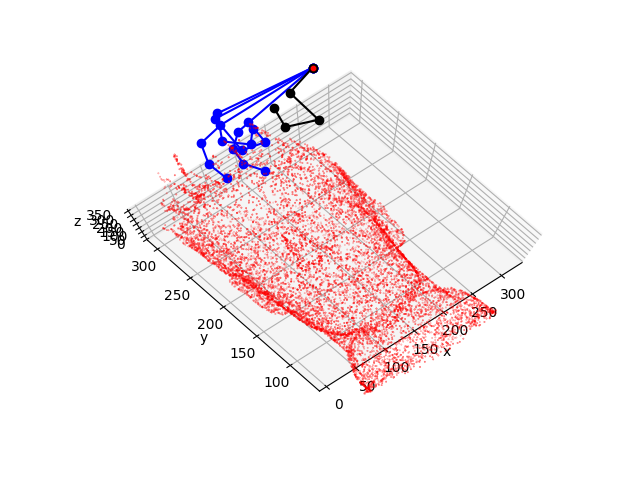

In [6]:
start = np.array(one_grasp['grasp_grasp_position'])[np.newaxis, 1:4].T
quat = np.array(one_grasp['grasp_grasp_position'])[4:8]

import hand

h = hand.makeHumanHand(start, quat)
hand_pts = h.getJointPositions()

h.updateDofs(np.array(one_grasp['grasp_grasp_joints'])[1:])
hand_pts = h.getJointPositions()
hand_pts = np.concatenate(hand_pts, axis=1).T

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

# Axis labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax = ax.axis('equal')

# Draw hand
plt.plot(np.append(hand_pts[0, 0], hand_pts[1:5, 0]),   np.append(hand_pts[0, 1], hand_pts[1:5, 1]),   np.append(hand_pts[0, 2], hand_pts[1:5, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[5:9, 0]),   np.append(hand_pts[0, 1], hand_pts[5:9, 1]),   np.append(hand_pts[0, 2], hand_pts[5:9, 2]), '-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[9:13, 0]),  np.append(hand_pts[0, 1], hand_pts[9:13, 1]),  np.append(hand_pts[0, 2], hand_pts[9:13, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[13:17, 0]), np.append(hand_pts[0, 1], hand_pts[13:17, 1]), np.append(hand_pts[0, 2], hand_pts[13:17, 2]),'-o', c= 'blue')
plt.plot(np.append(hand_pts[0, 0], hand_pts[17:21, 0]), np.append(hand_pts[0, 1], hand_pts[17:21, 1]), np.append(hand_pts[0, 2], hand_pts[17:21, 2]),'-o', c="black")

plt.show()

In [ ]:
# orientation = quat_to_rot(quat)

# deg2rad = np.pi / 180.

# RotX = rotation_matrix(-np.pi/2., np.array([1.,0.,0.])) 
# RotThumb = np.array([-0.1486, -0.9003, 0.4089, 0.2665, 0.3618, 0.8933, -0.9522, 0.2418, 0.1862]).reshape(3, 3).T

# # Offsets w.r.t parent coordinate frames with every 4 offsets corresponding to a finger
# # The first two joints per finger are assigned to a universal joint, so that's why one offset is always 0
# joint_offsets = [[-140.0599, 11.2048, 36.4156],  [-43.19, 0.0, 0.0], [-29.56, 0.0, 0.0], [-25.35, 0.0, 0.0], \
#                  [-145.6623, 11.2048, 8.4036],   [-46.20, 0.0, 0.0], [-30.99, 0.0, 0.0], [-29.20, 0.0, 0.0], \
#                  [-145.6623, 5.6025, -19.6084],  [-39.12, 0.0, 0.0], [-28.31, 0.0, 0.0], [-24.48, 0.0, 0.0], \
#                  [-134.4575, -8.4035, -42.0180], [-29.91, 0.0, 0.0], [-21.10, 0.0, 0.0], [-23.16, 0.0, 0.0], \
#                  [-50.6241, -11.5082, 18.9317],  [52.1193, 0.0, 0.0], [40.7638, 0.0, 0.0], [33.8, 0.0, 0.0]]

# # Joints may have have constant additions to their joint aingle dof
# # The thumb values in human hand xml file has angle offsets for the thumb joints
# joint_angle_offsets = [0., 0., 0., 0, \
#                        0, 0, 0, 0, \
#                        0, 0, 0, 0, \
#                        0, 0, 0, 0, \
#                        0, deg2rad*49.5, deg2rad*5.0, 0.0]


# h = HumanHand(start, orientation)
# h.addFinger(joint_offsets[0:4], RotX, joint_angle_offsets[0:4])         # fore finger
# h.addFinger(joint_offsets[4:8], RotX, joint_angle_offsets[4:8])         # middle
# h.addFinger(joint_offsets[8:12], RotX, joint_angle_offsets[8:12])       # ring
# h.addFinger(joint_offsets[12:16], RotX, joint_angle_offsets[12:16])     # pinky
# h.addFinger(joint_offsets[16:20], RotThumb, joint_angle_offsets[16:20]) # thumb

# h.updateJointPositions()

In [4]:
# import math

# def rotation_matrix(angle, direction, point=None):
#     sina = math.sin(angle)
#     cosa = math.cos(angle)
#     # rotation matrix around unit vector
#     R = np.diag([cosa, cosa, cosa])
#     R += np.outer(direction, direction) * (1.0 - cosa)
#     direction *= sina
#     R += np.array([[ 0.0,         -direction[2],  direction[1]],
#                       [ direction[2], 0.0,          -direction[0]],
#                       [-direction[1], direction[0],  0.0]])
#     return R

# # print(rotation_matrix(- np.pi / 2., np.array([1.,0.,0.]) ) @ np.array([-40.0,0,0]).T)
# def quat_to_rot(q):
#     # ref: https://www.lfd.uci.edu/~gohlke/code/transformations.py.html
#     n = np.dot(q, q)
#     q *= math.sqrt(2.0 / n)
#     q = np.outer(q, q)
#     return np.array([
#         [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0]],
#         [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0]],
#         [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2]]])

In [5]:
# class Joint:
    
#     def __init__(self, offset, R0, dof, parent=None):
#         self.dof_offset = dof
#         self.dof = 0
#         self.R = R0
#         self.t =  np.array([offset]).T
#         self.parent = parent
#         self.child = None
#         self.pos = np.zeros(3)
#         self.M = np.eye(3)
    
#     def setDofs(self, dofs):
#         if not len(dofs):
#             return
#         self.dof = dofs[0] + self.dof_offset               
#         if self.child != None:
#             self.child.setDofs(dofs[1:]) 
    
#     def updatePositions(self, transform, translate):
        
#         self.pos = translate + transform @ self.t
#         self.M = transform  @ self.R @ rotation_matrix(self.dof, np.array([0.,-1.,0.]))  
                
#         if self.child != None:
#            self.child.updatePositions(self.M, self.pos) 

# class UniversalJoint(Joint):
#     def __init__(self, offset, R0, dof1, dof2, parent=None):
#         super(UniversalJoint, self).__init__(offset, R0, dof1, parent)
#         self.dof1_offset = dof1
#         self.dof2_offset = dof2
#         self.dof1 = 0
#         self.dof2 = 0
    
#     def setDofs(self, dofs):
#         self.dof1 = dofs[0] + self.dof1_offset
#         self.dof2 = dofs[1] + self.dof2_offset

#         if self.child != None:
#             self.child.setDofs(dofs[2:])
            
#     def updatePositions(self, transform, translate):

#         self.pos = translate + transform @ self.t

#         self.M = transform  @ self.R @ rotation_matrix(self.dof2, np.array([0.,-1.,0.])) @ rotation_matrix(self.dof1, np.array([0.,0.,1.])) 
#         if self.child != None:
#             self.child.updatePositions(self.M, self.pos)
        

# class HumanHand:
#     """
#     Each finger is a list of joints. 
#     """
#     NUM_JOINTS = 20
#     NUM_FINGERS = 5
#     JOINTS_PER_FINGER = 4
    
#     def __init__(self, hand_pos, hand_orientation):
#         self.dofs = np.zeros(self.NUM_JOINTS)
#         self.root_translation = hand_pos
#         self.root_orientiation = hand_orientation
#         self.fingers = []

#     def addFinger(self, offsets, R0, dof0):
#         j0 = UniversalJoint(offsets[0], R0, dof0[0], dof0[1])
#         j1 = Joint(offsets[1], np.eye(3), dof0[2], j0)
#         j2 = Joint(offsets[2], np.eye(3), dof0[3], j1)
#         j3 = Joint(offsets[3], np.eye(3), 0, j2)
#         j0.child = j1
#         j1.child = j2
#         j2.child = j3
        
#         self.fingers.append(j0)
        
#     def updateDofs(self, dofs):
#         for i, joint in enumerate(self.fingers):
#             b = i*self.JOINTS_PER_FINGER
#             e = i*self.JOINTS_PER_FINGER + self.JOINTS_PER_FINGER
#             joint.setDofs(dofs[b:e]) 
#         self.updateJointPositions()
    
#     def updateJointPositions(self):
#         # compute position for each joint
#         for joint in self.fingers:
#             joint.updatePositions(self.root_orientiation, self.root_translation)
        
#     def getJointPositions(self):
#         print("Getting joint positions")
#         hand_pts = list()
        
#         hand_pts.append(self.root_translation)
#         for joint in self.fingers:
#             idx = 0
#             next_joint = joint
#             while next_joint != None:
#                 hand_pts.append(next_joint.pos)
#                 next_joint = next_joint.child
#                 idx+=1
#         return np.concatenate(hand_pts, axis=1).T


In [7]:
import open3d as o3
from open3d import JVisualizer


pcd = o3.PointCloud()
pcd.points = o3.Vector3dVector(pt_cld)

# o3.draw_geometries([pcd])
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()
# plt.show()



JVisualizer with 1 geometries